# Topic modeling - LDA Analysis

In this notebook we are going to implement a topic model, a type of statistical language models used for uncovering hidden structure in a collection of texts. It is particular type of unsupervised learning, where, like in clustering, the number of topics (clusters) is an input parameter. We will try to see whether we are able to recognize various topics people are talking about on Twitter.

In [1]:
import pandas as pd
import numpy as np
import os
from wordcloud import WordCloud
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()
import pickle 
pd.set_option('max_colwidth', None)
import tqdm

Let's start loading the data we scraped from Twitter.

In [2]:
df = pd.read_csv('data/tweets_processed.csv')
df.rename(columns={'lemmatized_tweets': 'Tweet', 'VADER_sentiment':'Sentiment'}, inplace=True)
df.head(50)

,Tweet,Sentiment
0,zydus group announce its new brand identity with the list entity of the group cadila healthcare limit to be now know as zyduslifescience limit more,Neutral
1,danger of take it or leave it compromise outcome on tripswaiver south africa express concern that the delay in approve a trip waiver be hamper effort to diversify proper production of vaccine amp address vaccine inequity covid,Negative
2,nstnation state health director dr othman warijo say the case involve a year old girl with a history of asthma who receive her vaccine at the sultanah bahiyah hospital kedah child vaccine covid pickid,Neutral
3,non medical face mask kn protect you from non oily airborne pollutant immunity vaccine testkit glove plymask ff kn,Positive
4,forsale vaccine covid covid medical life domain technology tech science medicine doctor daysofcode bot meme bigdata security cloud javascript java datascience machinelearne web nft vc investor socialmedia branding ai,Positive
5,by now the success of vaccine from and manipulate datum by pfizer about the vaccine be all over the world despite this if a tweet like this come suspect credential of the messager,Positive
6,another achievement in india 's fight against covid corbevax the makeinindia vaccine have be approve for emergency use for child in the age group of year indiafightscorona,Negative
7,australia epidemiologist warn it be too early to unwind covid health measure keep wear mask distance get booster vaccine covid aus covid au mask vaccines vaccination covid longcovid auspol nswpol qldpol saparli springst,Negative
8,multilingual news service arabic february news covid media coronavirus currentaffair breakingnews journalism corona trend latestnew politic article press community vaccine arabic,Neutral
9,ahmedabad have at least new slot available between amp covishield dose dose covaxin dose dose book one now at vaccine cowin covid ahmedabad,Neutral


We will also drop NA values, that were the result of data cleaning and lead to empyty text boxes.

In [3]:
df.dropna(inplace=True)

## Prepara data for LDA Analysis

Before running the LDA we are doing an additional cleanup to make sure that:

- we remove very common words in twets like *covid*, *dose*, *vaccine*, *vaccination*, *amp*, *coronavirus* that are not going to be very informative
- remove all other stop words (if any survived from previous cleanup) and puntuation
- all the sentences are processed through gensim pre-processor

NOTE: this step is not necessary but it will give us more peace of mind in case we didn't do a good job in the previous notebook or if we load ras data in this notebook.

We will also create a list lists containing all the words in each sentence during this step.

In [4]:
stop_words = stopwords.words('english')
stop_words.extend(['covid', 'dose', 'vaccine', 'vaccination', 'amp', 'coronavirus'])


def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

# Create the list of tweets
data = df['Tweet'].values.tolist()
# Create list of lists (words in sentences)
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)


This is what an exanple of input data looks like.

In [5]:
print(data_words[2])

['nstnation', 'state', 'health', 'director', 'dr', 'othman', 'warijo', 'say', 'case', 'involve', 'year', 'old', 'girl', 'history', 'asthma', 'receive', 'sultanah', 'bahiyah', 'hospital', 'kedah', 'child', 'pickid']


## WordCloud on Tweets

For fun we will also create a WordCloud of the tweets to see the most common words.

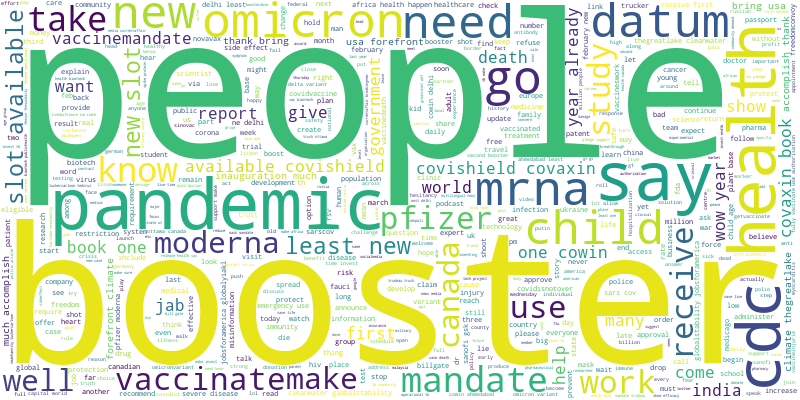

In [6]:
# Join the different processed titles together.
long_string = ','.join([', '.join(x) for x in data_words])
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=800, height=400)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [7]:
wordcloud.to_file('images/wordcloud.jpg')

## Build a Bi-gram model

In order to try to create a stronger model, we will also consider bi-grams or word couple that usually appear together in the corpus.

We will use gensim again to extract the bi-grams.

In [8]:
# Create the bi-gram model
bigram = gensim.models.Phrases(data_words, min_count=2, threshold=2) # higher threshold fewer phrases.
bigram_model = gensim.models.phrases.Phraser(bigram)

In [9]:
# Passing a list of words from the 6th sentence into the model as an example
print(bigram_model[data_words][2030])

['wow_year', 'already_since', 'inauguration_much', 'accomplish_thank', 'bring_usa', 'forefront_climate', 'thegreatlake_cleanwater', 'globalstability_jobsforamerica', 'globalyiakl']


In [10]:
# Creating the whole bi-gram corpus on all centences
norm_corpus_bigrams = [bigram_model[doc] for doc in data_words]

In [11]:
# One example
norm_corpus_bigrams[2030]

['wow_year',
 'already_since',
 'inauguration_much',
 'accomplish_thank',
 'bring_usa',
 'forefront_climate',
 'thegreatlake_cleanwater',
 'globalstability_jobsforamerica',
 'globalyiakl']

In [12]:
# And the processed tweet
df.iloc[2030, :]

Tweet        wow it have be a year already since your inauguration and so much accomplish thank you for bring usa to the forefront vaccine climate thegreatlake cleanwater globalstability jobsforamerica summitfordemocracy globalyiakl
Sentiment                                                                                                                                                                                                                       Positive
Name: 2086, dtype: object

In [13]:
# Create a dictionary representation of the documents.
dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
print('Sample word to number mappings:', list(dictionary.items())[:15])
print('Total Vocabulary Size:', len(dictionary))

Sample word to number mappings: [(0, 'announce'), (1, 'brand'), (2, 'cadila'), (3, 'entity'), (4, 'group'), (5, 'healthcare'), (6, 'identity'), (7, 'know'), (8, 'limit'), (9, 'list'), (10, 'new'), (11, 'zydus'), (12, 'address'), (13, 'approve'), (14, 'compromise')]
Total Vocabulary Size: 6435


In [14]:
list(dictionary.items())

[(0, 'announce'),
 (1, 'brand'),
 (2, 'cadila'),
 (3, 'entity'),
 (4, 'group'),
 (5, 'healthcare'),
 (6, 'identity'),
 (7, 'know'),
 (8, 'limit'),
 (9, 'list'),
 (10, 'new'),
 (11, 'zydus'),
 (12, 'address'),
 (13, 'approve'),
 (14, 'compromise'),
 (15, 'concern'),
 (16, 'danger'),
 (17, 'delay'),
 (18, 'diversify'),
 (19, 'effort'),
 (20, 'express'),
 (21, 'hamper'),
 (22, 'inequity'),
 (23, 'leave'),
 (24, 'outcome'),
 (25, 'production'),
 (26, 'proper'),
 (27, 'south_africa'),
 (28, 'take'),
 (29, 'trip'),
 (30, 'tripswaiver'),
 (31, 'waiver'),
 (32, 'asthma'),
 (33, 'bahiyah'),
 (34, 'case'),
 (35, 'child_pickid'),
 (36, 'director'),
 (37, 'dr'),
 (38, 'girl'),
 (39, 'health'),
 (40, 'history'),
 (41, 'hospital'),
 (42, 'involve'),
 (43, 'kedah'),
 (44, 'nstnation'),
 (45, 'othman'),
 (46, 'receive'),
 (47, 'say'),
 (48, 'state'),
 (49, 'sultanah'),
 (50, 'warijo'),
 (51, 'year_old'),
 (52, 'airborne'),
 (53, 'face'),
 (54, 'ff'),
 (55, 'glove'),
 (56, 'immunity'),
 (57, 'kn'),
 (5

## Transforming Corpus into Bag of Words

We will transform the corpus into a bag of words, were each word in the dictionary was assigned a number.

In [15]:
# Transforming corpus into bag of words vectors
bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print(bow_corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1)]


Looking at the first tweet above we can see each word represented by a tuple: the first number is the index that the word was assigned, the second number is the frequency in the sentence. 

Translation in words below.

In [16]:
print(bigram_model[data_words][0])

['zydus', 'group', 'announce', 'new', 'brand', 'identity', 'list', 'entity', 'group', 'cadila', 'healthcare', 'limit', 'know', 'limit']


In [17]:
print([(dictionary[idx] , freq) for idx, freq in bow_corpus[0]])

[('announce', 1), ('brand', 1), ('cadila', 1), ('entity', 1), ('group', 2), ('healthcare', 1), ('identity', 1), ('know', 1), ('limit', 2), ('list', 1), ('new', 1), ('zydus', 1)]


In [18]:
print('Total number of tweets:', len(bow_corpus))

Total number of tweets: 2037


## LDA with 3 Topics

We can now create the LDA model and to start we will try to bucket the tweets into three topics.

In [19]:
%%time
TOTAL_TOPICS = 3
lda_model = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, chunksize=2037, 
                                   alpha='auto', eta='auto', random_state=42,
                                   iterations=500, num_topics=TOTAL_TOPICS, 
                                   passes=20, eval_every=None)

CPU times: total: 4.86 s
Wall time: 4.87 s


Below are the most frequent words for each topic.

In [20]:
for topic_id, topic in lda_model.print_topics(num_topics=TOTAL_TOPICS, num_words=20):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.006*"get" + 0.005*"pandemic" + 0.004*"say" + 0.004*"mandate" + 0.003*"omicron" + 0.003*"health" + 0.003*"booster" + 0.003*"report" + 0.003*"people" + 0.002*"vaccinemandate" + 0.002*"disease" + 0.002*"cdc" + 0.002*"world" + 0.002*"know" + 0.002*"country" + 0.002*"go" + 0.002*"take" + 0.002*"canada" + 0.002*"tell" + 0.002*"like"

Topic #2:
0.004*"people" + 0.004*"say" + 0.004*"inauguration_much" + 0.004*"globalyiakl" + 0.004*"thegreatlake_cleanwater" + 0.004*"forefront_climate" + 0.004*"wow_year" + 0.004*"globalstability_jobsforamerica" + 0.004*"already_since" + 0.004*"bring_usa" + 0.004*"accomplish_thank" + 0.004*"go" + 0.004*"health" + 0.004*"cdc" + 0.003*"booster" + 0.003*"need" + 0.003*"least_new" + 0.003*"book_one" + 0.003*"cowin_delhi" + 0.003*"slot_available"

Topic #3:
0.004*"get" + 0.003*"take" + 0.003*"pfizer" + 0.003*"booster" + 0.003*"say" + 0.003*"news" + 0.003*"pandemic" + 0.003*"make" + 0.003*"people" + 0.002*"new" + 0.002*"virus" + 0.002*"would" + 0.002*"moder

It looks like:
- topic 1 is talking about what the pandemic that has brought a booster mandate becasue of Omicron
- topic 2 is talking about people think that has been wow year of global instability for jobs and climate because of the pandemic
- topic 3 is talking about pfizer and moderna booster in the news

Not bad!

We can also calculate the coherence metric. Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.

In [21]:
# Get the coherence score of first 20 words in each topic
topics_coherences = lda_model.top_topics(bow_corpus, topn=20)
# Average the coherence score for each topic
avg_coherence_score = np.mean([item[1] for item in topics_coherences])
print('Avg. Coherence Score:', avg_coherence_score)

Avg. Coherence Score: -10.112769390861507


Below are the weights of the top 20 words in each topic.

In [22]:
topics_with_wts = [item[0] for item in topics_coherences]
print('LDA Topics with Weights')
print('='*50)
for idx, topic in enumerate(topics_with_wts):
    print('Topic #'+str(idx+1)+':')
    print([(term, round(wt, 3)) for wt, term in topic])
    print()

LDA Topics with Weights
Topic #1:
[('get', 0.006), ('pandemic', 0.005), ('say', 0.004), ('mandate', 0.004), ('omicron', 0.003), ('health', 0.003), ('booster', 0.003), ('report', 0.003), ('people', 0.003), ('vaccinemandate', 0.002), ('disease', 0.002), ('cdc', 0.002), ('world', 0.002), ('know', 0.002), ('country', 0.002), ('go', 0.002), ('take', 0.002), ('canada', 0.002), ('tell', 0.002), ('like', 0.002)]

Topic #2:
[('get', 0.004), ('take', 0.003), ('pfizer', 0.003), ('booster', 0.003), ('say', 0.003), ('news', 0.003), ('pandemic', 0.003), ('make', 0.003), ('people', 0.003), ('new', 0.002), ('virus', 0.002), ('would', 0.002), ('moderna', 0.002), ('world', 0.002), ('read', 0.002), ('time', 0.002), ('year', 0.002), ('use', 0.002), ('research', 0.002), ('government', 0.002)]

Topic #3:
[('people', 0.004), ('say', 0.004), ('inauguration_much', 0.004), ('globalyiakl', 0.004), ('thegreatlake_cleanwater', 0.004), ('forefront_climate', 0.004), ('wow_year', 0.004), ('globalstability_jobsforamer

## Evaluating Topic Model Quality

There are different types of Coherence Measures
Let’s take quick look at different coherence measures, and how they are calculated:
- C_v measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity
- C_p is based on a sliding window, one-preceding segmentation of the top words and the confirmation measure of Fitelson’s coherence
- C_uci measure is based on a sliding window and the pointwise mutual information (PMI) of all word pairs of the given top words
- C_umass is based on document cooccurrence counts, a one-preceding segmentation and a logarithmic conditional probability as confirmation measure
- C_npmi is an enhanced version of the C_uci coherence using the normalized pointwise mutual information (NPMI)
- C_a is baseed on a context window, a pairwise comparison of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity

In [23]:
cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                      texts=norm_corpus_bigrams,
                                                      dictionary=dictionary, 
                                                      coherence='c_v')
avg_coherence_cv = cv_coherence_model_lda.get_coherence()

umass_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=bow_corpus, 
                                                         texts=norm_corpus_bigrams,
                                                         dictionary=dictionary, 
                                                         coherence='u_mass')
avg_coherence_umass = umass_coherence_model_lda.get_coherence()

perplexity = lda_model.log_perplexity(bow_corpus)

print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.33585303962079704
Avg. Coherence Score (UMass): -10.112769390861507
Model Perplexity: -8.266810698265436


We can see that the default coherence score is UMass. There is no one way to determine whether the coherence score is good or bad. The score and its value depend on the data that it’s calculated from. For instance, in one case, the score of 0.5 might be good enough but in another case not acceptable. The only rule is that we want to maximize this score.

## LDA tuning - Finding optimal number of Topics

In order to fine-tune the LDA model we run multiple models with increasing number of topics and we will chose the one that gives us the highest coherence score.

We will try from 2 to 11 topics.

In [24]:
def topic_model_coherence_generator(corpus, texts, dictionary, 
                                    start_topic_count=2, end_topic_count=10, step=1,
                                    cpus=1):
    
    models = []
    coherence_scores = []
    for topic_nums in tqdm.tqdm(range(start_topic_count, end_topic_count+1, step)):
        lda_model = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, chunksize=2037, 
                                   alpha='auto', eta='auto', random_state=42,
                                   iterations=500, num_topics=topic_nums, 
                                   passes=20, eval_every=None)
        cv_coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, corpus=corpus, 
                                                                     texts=texts, dictionary=dictionary, 
                                                                     coherence='c_v')
        coherence_score = cv_coherence_model_lda.get_coherence()
        coherence_scores.append(coherence_score)
        models.append(lda_model)
    
    return models, coherence_scores

In [25]:
num_topics = 10

In [26]:
lda_models, coherence_scores = topic_model_coherence_generator(corpus=bow_corpus, texts=norm_corpus_bigrams,
                                                               dictionary=dictionary, start_topic_count=2,
                                                               end_topic_count=num_topics+1, step=1, cpus=4)

100%|██████████| 10/10 [04:47<00:00, 28.75s/it]


Let's plot the top coherence scores vs. number of topics.

In [27]:
coherence_df = pd.DataFrame({'Number of Topics': range(2, 12, 1),
                             'Coherence Score': np.round(coherence_scores, 4)})
coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
7,9,0.4062
6,8,0.4032
5,7,0.3969
8,10,0.3947
9,11,0.3897
3,5,0.3681
4,6,0.3650
1,3,0.3359
2,4,0.3293
0,2,0.3123


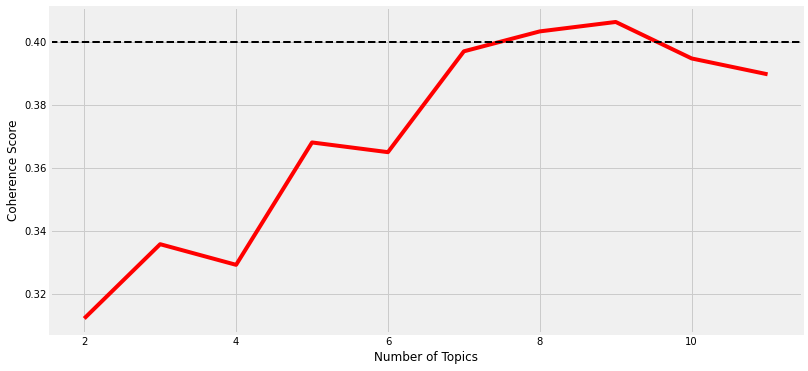

In [28]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

x_ax = range(2, num_topics+2, 1)
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.4, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

It looks like 9 topics gives us the best score. Let's fit and see the weights for the top 20 words in each topic.

In [29]:
best_model_idx = coherence_df[coherence_df['Number of Topics'] == 9].index[0]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

9

In [30]:
topics = [[(term, round(wt, 3)) 
               for term, wt in best_lda_model.show_topic(n, topn=20)] 
                   for n in range(0, best_lda_model.num_topics)]

for idx, topic in enumerate(topics):
    print('Topic #'+str(idx+1)+':')
    print([term for term, wt in topic])
    print()

Topic #1:
['get', 'health', 'say', 'doctor', 'people', 'cdc', 'report', 'booster', 'pandemic', 'mandate', 'video', 'share', 'vaccinemandate', 'us', 'datum', 'even', 'usa', 'omicron', 'covidvaccine', 'public']

Topic #2:
['forefront_climate', 'globalyiakl', 'inauguration_much', 'thegreatlake_cleanwater', 'globalstability_jobsforamerica', 'wow_year', 'bring_usa', 'already_since', 'accomplish_thank', 'book_one', 'least_new', 'covishield_covaxin', 'slot_available', 'cowin_delhi', 'go', 'people', 'india', 'work', 'country', 'canada']

Topic #3:
['one_cowin', 'available_covishield', 'new_slot', 'covaxin_book', 'get', 'year', 'ahmedabad', 'ahmedabad_least', 'new', 'news', 'booster', 'thank', 'pandemic', 'million', 'would', 'global', 'say', 'know', 'make', 'may']

Topic #4:
['free', 'people', 'study', 'low', 'call', 'side_effect', 'booster', 'february', 'know', 'follow', 'pm', 'get', 'first', 'pandemic_health', 'polio', 'today', 'help', 'say', 'omicron', 'immunity']

Topic #5:
['child', 'manda

## Conclusions

We can definitely identify what some of the topic are talking about while others are more trivial to understand. 

Neverthenless, we can see how with LDA we can extrapolate very useful information from text data.